# Introduction #

In this exercise, you'll build a model to predict hotel cancellations with a binary classifier.


In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

First, load the *Hotel Cancellations* dataset.

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('~/Desktop/Kaggle/practice/Intro_to_Deep_Learning/hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January': 1, 'February': 2, 'March': 3,
         'April': 4, 'May': 5, 'June': 6, 'July': 7,
         'August': 8, 'September': 9, 'October': 10,
         'November': 11, 'December': 12}
)

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"),  # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


# 1) Define Model #

The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

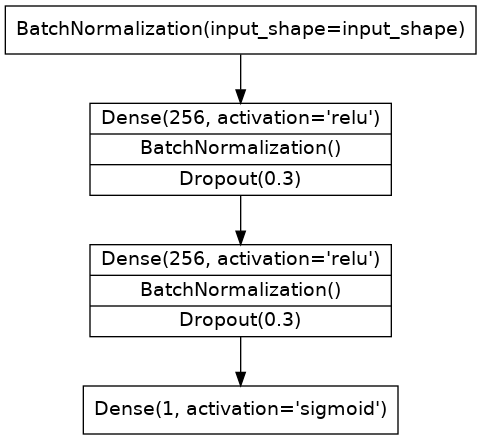

In [7]:
from IPython import display
display.Image("https://i.imgur.com/V04o59Z.png")


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

# define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid'),
])


# 2) Add Optimizer, Loss, and Metric #

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [5]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

Epoch 1/80
175/175 [==============================] - 2s 7ms/step - loss: 0.5424 - binary_accuracy: 0.7355 - val_loss: 0.4305 - val_binary_accuracy: 0.8089
Epoch 2/80
175/175 [==============================] - 1s 6ms/step - loss: 0.4300 - binary_accuracy: 0.7958 - val_loss: 0.4000 - val_binary_accuracy: 0.8133
Epoch 3/80
175/175 [==============================] - 1s 6ms/step - loss: 0.4116 - binary_accuracy: 0.8046 - val_loss: 0.3916 - val_binary_accuracy: 0.8201
Epoch 4/80
175/175 [==============================] - 1s 6ms/step - loss: 0.4010 - binary_accuracy: 0.8114 - val_loss: 0.3892 - val_binary_accuracy: 0.8218
Epoch 5/80
175/175 [==============================] - 1s 6ms/step - loss: 0.3959 - binary_accuracy: 0.8155 - val_loss: 0.3850 - val_binary_accuracy: 0.8227
Epoch 6/80
175/175 [==============================] - 1s 6ms/step - loss: 0.3886 - binary_accuracy: 0.8186 - val_loss: 0.3811 - val_binary_accuracy: 0.8274
Epoch 7/80
175/175 [==============================] - 1s 6ms/ste

<AxesSubplot:title={'center':'Accuracy'}>

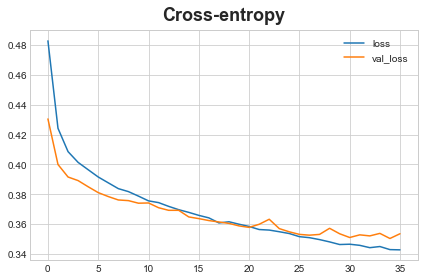

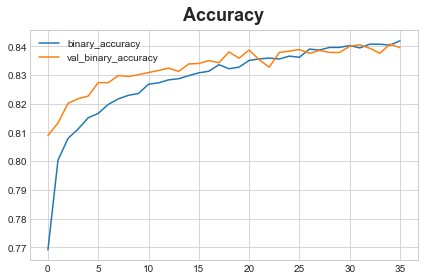

In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=80,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(
    title="Accuracy")


# 3) Train and Evaluate #


What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?

- Though we can see the training loss continuing to fall, the early stopping callback prevented any overfitting. Moreover, the accuracy rose at the same rate as the cross-entropy fell, so it appears that minimizing cross-entropy was a good stand-in. All in all, it looks like this training was a success!